## Run TCAV with Keras

with code from https://gist.github.com/Gareth001/e600d2fbc09e690c4333388ec5f06587

In [1]:
tcav = None

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot

#import keras_model as keras_model

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

import numpy as np
from nltk.corpus import wordnet as wn
import os
import operator
from os import listdir
from os.path import isfile, join
import subprocess
from PIL import Image
import requests
from io import BytesIO
import urllib.request

In [4]:
sess = K.get_session()

In [5]:
#model = InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.save('v3_model.h5')


In [6]:
tf.logging.set_verbosity(0)

model = None
model = load_model('v3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

In [8]:
tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

Instructions for updating:
Use tf.cast instead.


## Making Predictions

In [10]:
img_path = '/Users/tyler/Desktop/dissertation/programming/tcav/2012_val/val/ILSVRC2012_val_00000001.JPEG'

img_path = os.path.join(working_dir,'concepts/random500_3/ILSVRC2012_val_00017255.JPEG')

img = image.load_img(img_path, target_size=(299, 299))

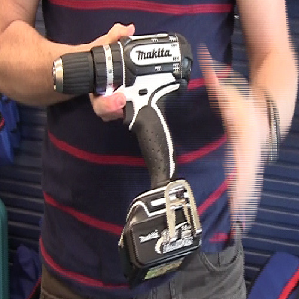

In [11]:
img

In [12]:
img_array = np.array(img)
x = np.expand_dims(img_array, axis=0)
x = preprocess_input(x)

In [13]:
pred = mymodel.get_predictions(x)
decode_predictions(pred, top=5)

[[('n03995372', 'power_drill', 0.9661025),
  ('n04086273', 'revolver', 0.0018131211),
  ('n02966687', "carpenter's_kit", 0.0017330588),
  ('n03527444', 'holster', 0.0009082831),
  ('n03602883', 'joystick', 0.00088521565)]]

## Run TCAV

In [14]:
#print(model.summary())

In [27]:
#working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
working_dir = '/home/tyler/Desktop/tcav_on_azure'

activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts/'

target = 'zebra'

concepts = ['dotted_sub_2']#,'striped_sub_2']   

#'mixed0','mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'mixed9', 'mixed9_1', 'mixed10'

bottlenecks = ['mixed9']

alphas = [0.1]

In [28]:
#source_dir

In [29]:
act_generator = None
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

In [30]:
act_generator.max_examples

50

In [31]:
tf.logging.set_verbosity(1)

mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir = cav_dir,
        num_random_exp=1)

INFO:tensorflow:mixed9 ['dotted_sub_2', 'random500_0'] zebra 0.1
INFO:tensorflow:TCAV will 1 params


In [32]:
results = mytcav.run(run_parallel=True)

INFO:tensorflow:running 1 params
INFO:tensorflow:running zebra ['dotted_sub_2', 'random500_0']
['dotted_sub_2', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_dotted_sub_2_mixed9 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Training CAV ['dotted_sub_2', 'random500_0'] - mixed9 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'dotted_sub_2': 1.0, 'random500_0': 0.9411764705882353, 'overall': 0.9696969696969697}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/dotted_sub_2-random500_0-mixed9-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:Done running 1 params. Took 13.726682186126709 seconds...


In [ ]:
#mymodel.ends

In [ ]:
results